# Lab:  Nonlinear Least-Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  

Suppose we wish to fit a model of the form,

     yhat ~= f(x,w)
     
where `x` is a vector of features, `w` is a vector of parameters and `f` is a nonlinear function of `w`.  Often we find the parameters `w` that minimize a squared-error cost of the form 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to the physical modeling of materials.  Specifically, we will estimate parameters in a model for the expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`. 

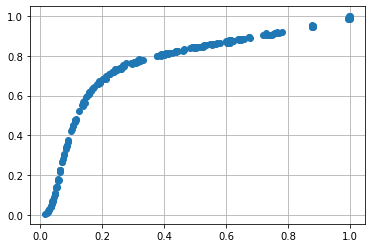

In [3]:
# TODO
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0) 
plt.plot(x,y,'o')
plt.grid()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

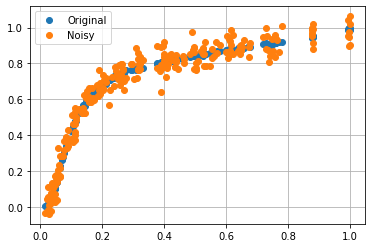

In [4]:
# TODO
yn = y + np.random.normal(0,0.05,len(y0))
plt.plot(x,y,'o')
plt.plot(x,yn,'o')
plt.legend(['Original', 'Noisy'])
plt.grid()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]`, so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[:d+1]
    b = w[d+1:]

    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order of a and b because np.polyval outputs
    #    a[0]*x**(d) + a[1]*x**(d-1) + ... + a[d-1]*x + a[d]
    arev = a[::-1]
    brev = b[::-1]
    znum = np.polyval(arev,x)
    zden = 1+x*np.polyval(brev,x)
    yhat = znum/zden
    return yhat

When we fit with a nonlinear model, most methods only obtain convergence to a *local* minimum, which is not necessarily good.  To converge to the *global* minimum, we need a good initialization.  For a rational model, one way to get a good initialization using the following trick.  First, realize that if

    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
then, by rearranging, we get

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
Note that this latter model is not useful for *prediction* because it is predicting `y` using `y`! But it *is* useful for least-squares fitting the parameters `a` and `b` when `y` and `x` are known as training samples.  

To do this least-squares fit, we can solve for parameter vector `w = [a0,a,b]` using linear regression with the newly defined `i`th feature vector

    Z[i,:] = [ x[i], ... , x[i]**d, -y[i]*x[i], ... , -y[i]*x[i]**d ].
    
Here, `a=[a[1],...,a[d]]`, `b=[b[0],...,b[d-1]]`, and `a0` is the intercept term of the linear model.  We don't put the intercept in the `a` and `b` vectors because sklearn's `LinearRegression` method will handle it separately.

As a hint for the next block, realize that a matrix with rows `[ x[i], x[i]**2, ... , x[i]**d]` can be efficiently created using broadcasting as `xtr[:,None]**powd[None,:]`, where `powd = [1,...,d]`.  For more on broadcasting, see the demo in Unit 0, especially the "outer product" section.  

In [7]:
d = 3

# TODO.  Create the transformed feature matrix
powd = np.arange(1,d+1)
Znum = xtr[:,None]**powd[None,:]
Zden = -ytr[:,None]*Znum
Z = np.hstack((Znum, Zden))


# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
a0 = regr.intercept_
ab = regr.coef_
winit = np.hstack((a0,ab))


Now using the `predict` function and your initial parameter estimate `winit`, compute `yhat` for 1000 values of `x` uniformly spaced over the interval `[0,1]`.  Plot `yhat` versus `x`.  You should see that the prediction curve has some singularities.  On the same plot, superimpose the points `(xts,yts)`.  Use the `axis` command to focus your plot on the region near the data samples.

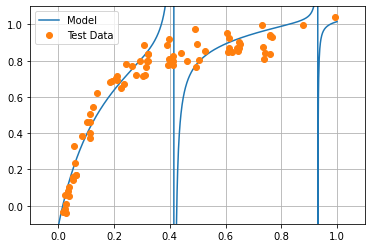

In [8]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp = np.linspace(0,1,1000)
yhat  = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts, yts, 'o')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.legend(['Model', 'Test Data'])
plt.grid()

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To alleviate this problem, we can use Ridge regression instead of least-squares, in order to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-1`. You should see a much better (but not perfect) fit.

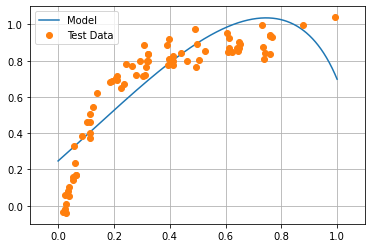

In [9]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=1e-1)
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
a0 = regr.intercept_
ab = regr.coef_
winit = np.hstack((a0,ab))

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat  = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts, yts, 'o')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.legend(['Model', 'Test Data'])
plt.grid()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate of the weights `w`.  Complete the construction of the following function, which is used to compute the RSS-like cost

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
    
    # TODO.  Parse w
    # a = ...
    # b = ...
    d = (len(w)-1)//2
    a = w[:d+1]
    b = w[d+1:]

    # TODO.  
    # Znum = ... # so that Znum[i,j] = x[i]**j
    pow1 = np.arange(0,d+1)
    Znum = x[:,None]**pow1[None,:]

    # TODO.  
    # Zden = ... # so that Zden[i,j] = x[i]**(j+1)
    pow2 = np.arange(1,d+1)
    Zden = x[:,None]**pow2[None,:]

    # TODO.  Compute yhat 
    # Compute the numerator and denominator using Znum, Zden, a, and b
    rnum = Znum.dot(a)
    rden = Zden.dot(b)
    yhat = rnum/(1+rden)

    # TODO.  Compute loss
    e = yhat-y
    f = 0.5*np.sum(e**2)

    # TODO.  Compute gradients
    eden = e/(1+rden)
    dJ_da = eden.dot(Znum)
    enum = -e*yhat/(1+rden)
    dJ_db = enum.dot(Zden)    
    fgrad = np.hstack((dJ_da, dJ_db))
    
    return f, fgrad

Now, test your gradient computation:
* Set `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Make a `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
w0 = winit
p = len(winit)
w1 = w0 + np.random.normal(0,1,p)*1e-6
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad1 = feval(w1,xtr,ytr)

print([f1-f0, fgrad0.dot(w1-w0)])
fgrad1

[1.1381164301882407e-05, 1.1380185796371152e-05]


array([-3.72823322, -4.1567872 , -4.86106913, -5.73238677,  1.20810567,
        2.35447124,  3.33692935])

If the gradient test fails, don't move forward until you fix the problem!

## Implement gradient descent

We will now try to minimize the loss function using gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it` on a log-log scale.  

You should see that the training loss decreases but does not fully converge after 10000 iterations.

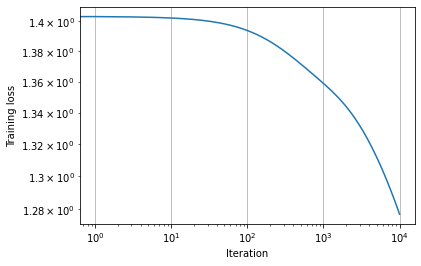

In [19]:
# TODO
nit = 10000
step = 1e-6
fgd = np.zeros(nit)
wt = winit
for it in range(nit):
    ft, fgradt = feval(wt,xtr,ytr)
    fgd[it] = ft                
    wt  = wt - step*fgradt
        
plt.loglog(fgd)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid()

Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `fadapt[it]` be the loss value that it attains on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same log-log graph.  You should see some improvement, but also some lingering problems.

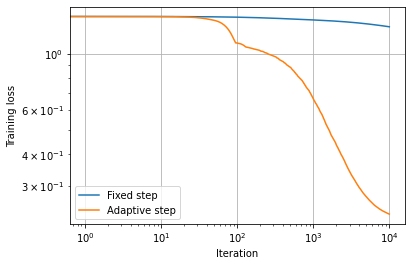

In [25]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
w0 = winit
fadapt = np.zeros(nit)
f0, fgrad0 = feval(w0,xtr,ytr)
for it in range(nit):
    
    # Compute test point
    w1 = w0 - step*fgrad0
    f1, fgrad1 = feval(w1,xtr,ytr)            

    # Implement Armijo rule
    alpha = 0.5
    if (f1-f0 < alpha*fgrad0.dot(w1-w0)) and (f1 < f0):
        step = 1.1*step
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        step = 0.5*step
    fadapt[it] = f0                
    
    
plt.loglog(fgd)
plt.loglog(fadapt)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend(['Fixed step', 'Adaptive step'])
plt.grid()

Using the final estimate for `w` from the adaptive step-size approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot the test data, `yts` vs. `xts`.  You should see that gradient descent was able to improve the prediction model, although the initial prediction model was not too bad.

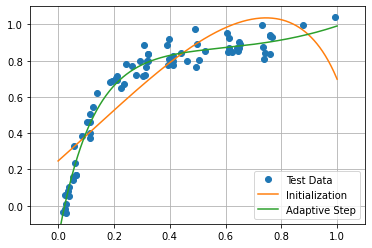

In [26]:
# TODO
xp = np.linspace(0,1,500)
yinit = predict(winit,xp)
yhat = predict(w0,xp)
plt.plot(xts,yts,'o')
plt.plot(xp,yinit,'-')
plt.plot(xp,yhat,'-')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.legend(['Test Data', 'Initialization', 'Adaptive Step'])
plt.grid()

## Momentum Gradient Descent

This section is optional.

One way to improve gradient descent is to use *momentum*.  With momentum, the gradient-descent update rule becomes:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that the update direction `z` is the sum of the gradient `fgrad` and the previous update direction `z`, which tends to keep the algorithm moving in the same direction (instead of randomly changing directions, as it would if `z=fgrad`).  Implement momentum gradient-descent with `beta = 0.99` and `step=1e-5`.  Compare the convergence of this approach to plain gradient descent and the adaptive stepsize version.  

In [15]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99

Using the final estimate for `w` from the momentum approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the adaptive stepsize method.  Also, plot the test data, `yts` vs. `xts`.  You should see that the momentum approach gives a slightly different prediction model than the adaptive-stepsize approach.

In [16]:
# TODO
# plot yhat vs. x